# Instruction to lab work # 3: Lazy learner k-Nearest Neighbour

> Student name    - Maksym

> Student surname - Malituin

> Group           - CS-31

# Description of the work

## Theory
* [Lazy Learning Wiki](https://en.wikipedia.org/wiki/Lazy_learning)
* [k-Nearest Neighbour Wiki](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

### k-NN metrics:
* `n_neighbours` -- number neighbours to vote
* `p` -- the distance metric (Euclid Distance, Mahalanobis Distance, Manhattan Distance (L1), L2, cosine, and [other available metric could be found here](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html))

## Datasets to use (just use that one from the 2nd lab work)

1. [Liver Cirrhosis Stage Classification](https://www.kaggle.com/datasets/aadarshvelu/liver-cirrhosis-stage-classification)
2. [Star Dataset for Stellar Classification](https://www.kaggle.com/datasets/vinesmsuic/star-categorization-giants-and-dwarfs)
3. [Fitness Classification Dataset](https://www.kaggle.com/datasets/muhammedderric/fitness-classification-dataset-synthetic)
4. [ECG Arrhythmia Classification Dataset](https://www.kaggle.com/datasets/sadmansakib7/ecg-arrhythmia-classification-dataset)
5. [Mushroom Classification Enhanced](https://www.kaggle.com/datasets/sakurapuare/mushroom-classification-enhanced)
6. [Dry Bean Dataset Classification](https://www.kaggle.com/datasets/nimapourmoradi/dry-bean-dataset-classification)
7. [Swarm Behaviour Classification](https://www.kaggle.com/datasets/deepcontractor/swarm-behaviour-classification) -- challenging one 270 Mb dataset
8. [Anemia Types Classification](https://www.kaggle.com/datasets/ehababoelnaga/anemia-types-classification)
9. [NASA: Asteroids Classification](https://www.kaggle.com/datasets/shrutimehta/nasa-asteroids-classification)

## Task description

1. Build lazy learner as was shown in the experiment part.
2. Do experiments with various metrics (not only included in the list)
3. Do experiments with various data separations.
4. WARNING: for testing while doing experiments on non-toy data do train-val-test data split. It'll show more realistic performance of your model.
5. WARNING: for unbalanced data prefer using other metrics (not "accuracy", but "f1-macro" / "precision" / "recall"), be inventive in this question.


# Import dependencies

In [85]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm import tqdm

# Some useful code

In [86]:
def plot_classifier_boundary(X, y, model=None, title=None, resolution=200):
    """
    Visualizes classifier decision boundaries using a high-resolution, evenly-spaced grid.

    If a model is provided, it plots the decision regions.
    If model is None, it only plots the data points.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The true label vector, shape (n_samples,).
    :param model: A trained scikit-learn classifier object. Optional.
    :param title: The title for the plot. A default is used if None.
    :param resolution: The number of points to use per axis for the background grid.
    """
    plt.style.use('seaborn-v0_8-pastel')
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the background decision regions only if a model is provided
    if model is not None:
        # 1. Define the plot boundaries with a 10% padding
        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_pad = (x1_max - x1_min) * 0.2
        x2_pad = (x2_max - x2_min) * 0.2
        plot_x1_min, plot_x1_max = x1_min - x1_pad, x1_max + x1_pad
        plot_x2_min, plot_x2_max = x2_min - x2_pad, x2_max + x2_pad

        # 2. Create a high-resolution, evenly-spaced grid of points
        xx1, xx2 = np.meshgrid(
            np.linspace(plot_x1_min, plot_x1_max, resolution),
            np.linspace(plot_x2_min, plot_x2_max, resolution)
        )
        
        # 3. Get the model's prediction for every point on the grid
        # We flatten the grid to pass it to the model, then reshape the predictions back
        grid_points = np.c_[xx1.ravel(), xx2.ravel()]
        Z = model.predict(grid_points)
        Z = Z.reshape(xx1.shape)
        
        # 4. Plot the regions using filled contours
        ax.contourf(xx1, xx2, Z, cmap=plt.cm.coolwarm, alpha=0.6)

    # 5. Plot the original data points on top
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=1.0, zorder=2)

    # Set a dynamic title if none is provided
    if title is None:
        title = "Classifier Decision Boundary" if model is not None else "Data Scatter Plot"
    
    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    # --- Legend Creation ---
    handles, _ = scatter.legend_elements()
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]
    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)
    
    if model is not None:
        ax.set_xlim(plot_x1_min, plot_x1_max)
        ax.set_ylim(plot_x2_min, plot_x2_max)
    
    plt.show()

## 2. Own experiments on the NASA: Asteroids Classification Dataset

## 2.1. Data Loading

In [87]:
# 2.1 Завантаження даних
try:
    df = pd.read_csv("nasa.csv")
    print(f"Датасет успішно завантажено. Форма: {df.shape}")
    print("Перші 5 рядків:")
    display(df.head()) # display() краще для .ipynb
except FileNotFoundError:
    print("ПОМИЛКА: Файл nasa.csv не знайдено")
    df = pd.DataFrame() # Створюємо заглушку

Датасет успішно завантажено. Форма: (4687, 40)
Перші 5 рядків:


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


## 2.1.1 Feature (X) and Target (y) Selection

In [88]:
if not df.empty:
    # 2. Вибір ознак (X) та цільової змінної (y)
    # Цільова змінна - 'Hazardous'
    y_df = df['Hazardous']
    
    # Видаляємо ID, імена, дати та інші нечислові або непотрібні колонки
    # 'Orbiting Body' та 'Equinox' мають лише одне значення ('Earth', 'J2000') і не несуть користі
    irrelevant_cols = [
        'Neo Reference ID', 'Name', 'Orbit ID', 'Orbit Determination Date', 
        'Close Approach Date', 'Epoch Date Close Approach', 'Equinox', 
        'Orbiting Body', 'Hazardous'
    ]
    
    # Перевіримо, чи всі колонки існують, перш ніж їх видаляти
    cols_to_drop = [col for col in irrelevant_cols if col in df.columns]
    X_df = df.drop(columns=cols_to_drop)
    
    print(f"Обрано {X_df.shape[1]} ознак для X.")
    print("Список ознак:", list(X_df.columns))

Обрано 31 ознак для X.
Список ознак: ['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Relative Velocity km per sec', 'Relative Velocity km per hr', 'Miles per hour', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance', 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion']


## 2.1.2 Handling Missing Values and Target Encoding

In [89]:
if not df.empty:
    # 3. Обробка пропущених значень (якщо є)
    if X_df.isnull().sum().any():
        print("Знайдено пропущені значення. Заповнення середнім...")
        X_df = X_df.fillna(X_df.mean())
    else:
        print("Пропущених значень не знайдено.")

    # 4. Кодування цільової змінної (True/False -> 1/0)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_df)
    
    print(f"\nКласи цільової змінної: {label_encoder.classes_} -> {np.unique(y_encoded)}")

Пропущених значень не знайдено.

Класи цільової змінної: [False  True] -> [0 1]


## 2.1.3 Class Balance Analysis

Баланс класів:
0    83.89%
1    16.11%
Name: proportion, dtype: object


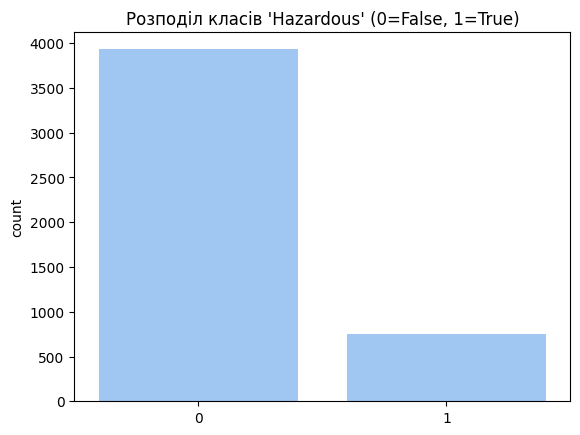


P.S. Датасет сильно незбалансований
Будемо використовувати f1-macro як основну метрику.


In [90]:
if not df.empty:
    # 5. Перевірка балансу класів
    print("Баланс класів:")
    class_balance = pd.Series(y_encoded).value_counts(normalize=True) * 100
    print(class_balance.round(2).astype(str) + '%')
    
    # Візуалізація балансу
    sns.countplot(x=y_encoded)
    plt.title("Розподіл класів 'Hazardous' (0=False, 1=True)")
    plt.show()
    
    if class_balance.min() < 20: # 20% поріг
        print("\nP.S. Датасет сильно незбалансований")
        print("Будемо використовувати f1-macro як основну метрику.")
        main_metric = 'f1-macro'
    else:
        main_metric = 'accuracy'

## 2.1.4 Feature Scaling

In [91]:
if not df.empty:
    # 6. Масштабування ознак
    print("Масштабування ознак за допомогою StandardScaler...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_df)
    
    print(f"Дані успішно підготовлено та масштабовано!")
    print(f"X_scaled shape: {X_scaled.shape}, y_encoded shape: {y_encoded.shape}")

Масштабування ознак за допомогою StandardScaler...
Дані успішно підготовлено та масштабовано!
X_scaled shape: (4687, 31), y_encoded shape: (4687,)


## 2.1.5 Data Splitting (Train-Val-Test)

In [92]:
# Загальне співвідношення: 70% (train+val) / 30% (test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, 
    y_encoded, 
    test_size=0.3, # 30% на тест
    random_state=42,
    stratify=y_encoded # Дуже важливо для незбалансованих даних
)

# Розділяємо 70% на 80/20: 80% (навчання) / 20% (валідація)
# Це дасть ~56% (train) / 14% (val) / 30% (test) від загальної вибірки
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2, # 20% на валідацію
    random_state=42,
    stratify=y_train_full # Зберігаємо баланс
)

print(f"Загальний розмір: {len(y_encoded)}")
print(f"Розмір Train (для експериментів): {len(y_train)}")
print(f"Розмір Validation (для оцінки): {len(y_val)}")
print(f"Розмір Test (для фінальної оцінки): {len(y_test)}")

Загальний розмір: 4687
Розмір Train (для експериментів): 2624
Розмір Validation (для оцінки): 656
Розмір Test (для фінальної оцінки): 1407


## 2.2. Running Experiments

In [93]:
experiment_results = []

# 1. Експеримент зі співвідношенням даних (data separation)
train_size_percents = np.arange(0.1, 1.0, 0.2) # [0.1, 0.3, 0.5, 0.7, 0.9]

# 2. Експеримент з метриками
metrics_to_test = ["euclidean", "manhattan", "cosine", "chebyshev"]

# 3. Експеримент з 'k'
k_values = [1, 3, 5, 7, 11, 15, 21, 31] # Набір значень 'k'

print(f"Розпочинаємо експерименти... Всього ітерацій: {len(train_size_percents) * len(metrics_to_test) * len(k_values)}")

for train_size in tqdm(train_size_percents):
    
    discard_percent = 1.0 - train_size
    
    # Використовуємо наш 'X_train' для створення під-вибірок
    X_train_mem, _, y_train_mem, _ = train_test_split(
        X_train, 
        y_train,
        test_size=discard_percent,
        random_state=42,      
        stratify=y_train        
    )
    
    if len(y_train_mem) == 0:
        continue

    for metric in metrics_to_test:
        for k in k_values:
            if k > len(y_train_mem):
                continue 
                
            try:
                knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1) 
                knn_model.fit(X_train_mem, y_train_mem)
                
                y_val_pred = knn_model.predict(X_val)
                
                score = f1_score(y_val, y_val_pred, average='macro')
                
                experiment_results.append((metric, train_size, k, score))
            
            except Exception as e:
                print(f"Помилка: k={k}, metric={metric}, train_size={train_size}. {e}")

print("\nЕксперименти завершено.")

Розпочинаємо експерименти... Всього ітерацій: 160


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Експерименти завершено.


In [94]:
experiment_results

[('euclidean', np.float64(0.1), 1, 0.674948679832944),
 ('euclidean', np.float64(0.1), 3, 0.6920143073564787),
 ('euclidean', np.float64(0.1), 5, 0.6830917874396135),
 ('euclidean', np.float64(0.1), 7, 0.6910032972209138),
 ('euclidean', np.float64(0.1), 11, 0.6325623839642531),
 ('euclidean', np.float64(0.1), 15, 0.5649004765909728),
 ('euclidean', np.float64(0.1), 21, 0.493934351837846),
 ('euclidean', np.float64(0.1), 31, 0.4657773296622329),
 ('manhattan', np.float64(0.1), 1, 0.725752508361204),
 ('manhattan', np.float64(0.1), 3, 0.7309539052496798),
 ('manhattan', np.float64(0.1), 5, 0.712303505851893),
 ('manhattan', np.float64(0.1), 7, 0.7286789643477541),
 ('manhattan', np.float64(0.1), 11, 0.6760733772806953),
 ('manhattan', np.float64(0.1), 15, 0.6260197762881126),
 ('manhattan', np.float64(0.1), 21, 0.5082458770614693),
 ('manhattan', np.float64(0.1), 31, 0.48471329321955053),
 ('cosine', np.float64(0.1), 1, 0.6771638967524053),
 ('cosine', np.float64(0.1), 3, 0.668857525497

## 2.2.1 Experiment Results Analysis (Visualization)

In [95]:
# Створюємо DataFrame з результатами
results_df = pd.DataFrame(
    experiment_results, 
    columns=["metric", "train_size_percent", "k", "f1_macro"]
)

print("Топ 5 найкращих комбінацій на валідаційному наборі:")
display(results_df.sort_values(by="f1_macro", ascending=False).head())

# Візуалізація результатів
for metric in metrics_to_test:
    vis_data = results_df[results_df["metric"] == metric]
    
    if vis_data.empty:
        print(f"Немає даних для метрики: {metric}")
        continue

    fig = px.scatter_3d(
        vis_data, 
        x='train_size_percent', 
        y='k', 
        z='f1_macro',
        title=f"k-NN F1-macro (Val) на NASA data, метрика=<b>{metric}</b>",
        color="f1_macro",
        color_continuous_scale=px.colors.sequential.Viridis,
        width=800, height=700
    )
    
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(
        scene=dict(
            xaxis_title='Розмір навч. вибірки (%)',
            yaxis_title='Кількість сусідів (k)',
            zaxis_title='F1-macro'
        )
    )
    fig.show()

Топ 5 найкращих комбінацій на валідаційному наборі:


,metric,train_size_percent,k,f1_macro
137,manhattan,0.9,3,0.837101
139,manhattan,0.9,7,0.829325
105,manhattan,0.7,3,0.817823
144,cosine,0.9,1,0.815654
140,manhattan,0.9,11,0.815628


## 2.2.2 Best Model Selection and Evaluation on Test Set

Найкраща модель (за результатами валідації при max train_size):
metric                manhattan
train_size_percent          0.9
k                             3
f1_macro               0.837101
Name: 137, dtype: object

Навчання фінальної моделі з k=3 та metric='manhattan' на 3280 зразках.

--- Звіт класифікації для ТЕСТОВОГО набору ---
                    precision    recall  f1-score   support

 Безпечний (False)       0.93      0.95      0.94      1180
Небезпечний (True)       0.71      0.61      0.66       227

          accuracy                           0.90      1407
         macro avg       0.82      0.78      0.80      1407
      weighted avg       0.89      0.90      0.89      1407

Матриця помилок для ТЕСТОВОГО набору:


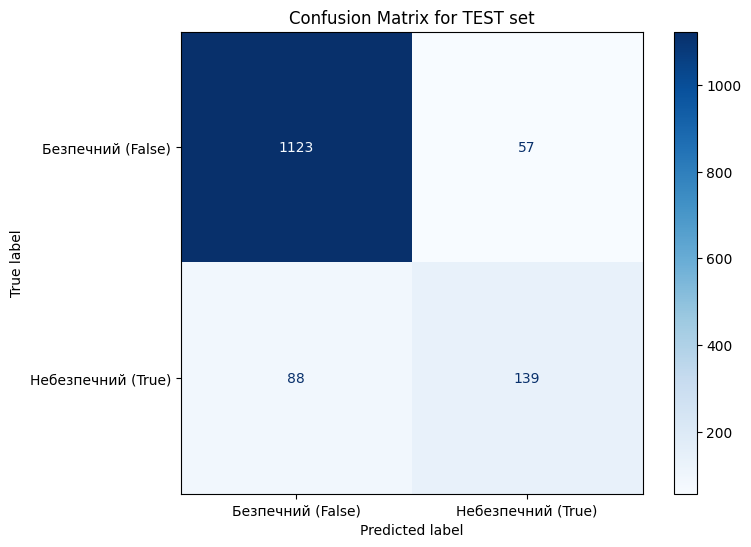

In [96]:
# 1. Знаходимо найкращі гіперпараметри з нашого експерименту
best_params_df = results_df[results_df['train_size_percent'] == results_df['train_size_percent'].max()]
best_overall = best_params_df.loc[best_params_df['f1_macro'].idxmax()]

print(f"Найкраща модель (за результатами валідації при max train_size):")
print(best_overall)

best_k = int(best_overall['k'])
best_metric = best_overall['metric']

# 2. Тепер тренуємо фінальну модель на ВСІХ тренувальних даних (X_train_full)
final_knn_model = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, n_jobs=-1)
final_knn_model.fit(X_train_full, y_train_full)

print(f"\nНавчання фінальної моделі з k={best_k} та metric='{best_metric}' на {len(y_train_full)} зразках.")

# 3. Оцінюємо на тестовому наборі (X_test, y_test)
y_test_pred = final_knn_model.predict(X_test)

print("\n--- Звіт класифікації для ТЕСТОВОГО набору ---")
class_names = ['Безпечний (False)', 'Небезпечний (True)']
print(classification_report(y_test, y_test_pred, target_names=class_names))

# 4. Побудова матриці помилок
print("Матриця помилок для ТЕСТОВОГО набору:")
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(False)

ConfusionMatrixDisplay.from_estimator(
    final_knn_model, 
    X_test, 
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    ax=ax,
)

plt.title("Confusion Matrix for TEST set")
plt.show()

## 2.2.3 Decision Boundary Visualization (via PCA)


Візуалізація межі рішень за допомогою PCA (зменшення до 2D)
Малюємо межу рішень (k=3, metric='manhattan') для даних, навчених на PCA


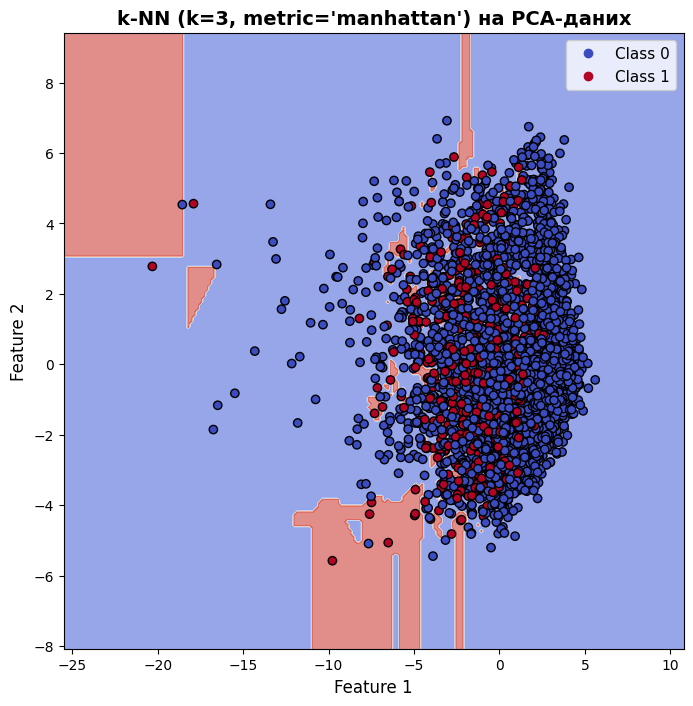

In [97]:
print("\nВізуалізація межі рішень за допомогою PCA (зменшення до 2D)")

# 1. Зменшуємо розмірність X_train_full до 2 компонент
pca = PCA(n_components=2)
X_train_full_pca = pca.fit_transform(X_train_full)

# 2. Навчаємо k-NN на цих 2D даних
knn_pca_model = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn_pca_model.fit(X_train_full_pca, y_train_full)

# 3. Візуалізуємо
print(f"Малюємо межу рішень (k={best_k}, metric='{best_metric}') для даних, навчених на PCA")
plot_classifier_boundary(
    X_train_full_pca, 
    y_train_full, 
    model=knn_pca_model, 
    title=f"k-NN (k={best_k}, metric='{best_metric}') на PCA-даних"
)

# Conclusions

Під час виконання цієї лабораторної роботи я ознайомився з "лінивим" алгоритмом k-NN на прикладі датасету NASA: Asteroids Classification. Ключовим викликом стала сильна незбалансованість класів, що вимагало використання метрики f1-macro замість звичайної точності. Також, оскільки k-NN базується на відстанях, обов'язковим кроком було масштабування всіх ознак за допомогою StandardScaler.

За прикладами вишче, я реалізував train-val-test розділення даних. Це дозволило коректно провести експерименти, перебираючи різні метрики (euclidean, manhattan та ін.), кількість сусідів (k) та обсяг навчальних даних на валідаційному наборі.

За результатами експериментів, найкращу якість (f1-macro = 0.837) показала модель з параметрами metric = 'manhattan' та k = 3. Цю фінальну модель було навчено на повному тренувальному наборі та протестовано на "небачених" тестових даних, де вона досягла фінального f1-macro = 0.80. Робота продемонструвала, що ефективність k-NN критично залежить від підготовки даних (масштабування) та ретельного підбору гіперпараметрів.